In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
# import statsmodels.api as sm
from tqdm import tqdm
# from multiprocessing.dummy import Pool
import dask.dataframe as dd

pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# pd.set_option('display.max_columns', 500)

In [9]:
#In[] 1,227,297,915 size, 7675it * 10000
crsp_df = pd.read_csv("crsp_d.csv",header=0,
    parse_dates = ['date','DCLRDT','RCRDDT'],
    dtype={
        "PERMNO": str,
        "PRC": np.float64,
        "VOL": np.float64,
        "SHROUT": np.float64,
        "DIVAMT": np.float64,
        "SHRCD":str,
        "DISTCD":str,
        "COMNAM": str,
        "TICKER": str,
        'CUSIP': str,
        "BID": np.float64,
        "ASK": np.float64}, chunksize=100000)
#Data Preprocessing
#In[]
d = {}
one = False
def insert(i,x):
    if str(x)[-1].isdigit() == False:
        return
    x = float(x)
    if i not in d:
        d[i] = [x]
    else:
        d[i].append(x)
    return
cache = []
cache_ddate = set()
for c in tqdm(crsp_df):
    c = c[(c.SHRCD.isin(('10','11'))) ]
    c = c.groupby(by=['CUSIP','date']).agg({
          'DCLRDT': 'last',
          'RCRDDT': 'last',
          'DISTCD': 'last',
          'DIVAMT': 'sum',
          'RET':'last',
          'RETX':'last',
          'PRC': 'last'}).reset_index()
    if not one:
         cusip = c.head(1).reset_index().iloc[0].CUSIP
         one = True
    count = 0
    # c['dt'] = 0
    lastDivDate = None
    for row in c.itertuples():
        if row.CUSIP != cusip:
            cusip = row.CUSIP
            count = 0
            lastDivDate = None
            for row2 in cache:
                if row2[0] in cache_ddate:
                    count = 0
                    insert(count, row2[1])
                    cache_ddate.remove(row2[0])
                    count += 1
                    lastDivDate = True
                elif lastDivDate is not None:
                    insert(count, row2[1])
                    count += 1
            cache = list()
            cache_ddate = set()
        else:
            cache.append((row.date, row.RET))
            if pd.isna(row.DCLRDT) == False:
                cache_ddate.add(row.DCLRDT)
for row2 in cache:
    if row2[0] in cache_ddate:
        count = 0
        insert(count, row2[1])
        cache_ddate.remove(row2[0])
        count += 1
        lastDivDate = True
    elif lastDivDate is not None:
        insert(count, row2[1])
        count += 1        

819it [24:28,  1.79s/it]


In [10]:
#In[] 1,227,297,915 size, 7675it * 10000
crsp_df = pd.read_csv("crsp_d_rev2.csv",header=0,
    parse_dates = ['date','DCLRDT','RCRDDT'],
    dtype={
        "PERMNO": str,
        "PRC": np.float64,
        "VOL": np.float64,
        "SHROUT": np.float64,
        "DIVAMT": np.float64,
        "SHRCD":str,
        "DISTCD":str,
        "COMNAM": str,
        "TICKER": str,
        'CUSIP': str,
        "BID": np.float64,
        "ASK": np.float64}, chunksize=100000)
#Data Preprocessing
#In[]
def insert(i,x):
    if str(x)[-1].isdigit() == False:
        return
    x = float(x)
    if i not in d:
        d[i] = [x]
    else:
        d[i].append(x)
    return
one = False
cache = []
cache_ddate = set()
for c in tqdm(crsp_df):
    c = c[(c.SHRCD.isin(('10','11'))) ]
    c = c.groupby(by=['CUSIP','date']).agg({
          'DCLRDT': 'last',
          'RCRDDT': 'last',
          'DISTCD': 'last',
          'DIVAMT': 'sum',
          'RET':'last',
          'RETX':'last',
          'PRC': 'last'}).reset_index()
    if not one:
         cusip = c.head(1).reset_index().iloc[0].CUSIP
         one = True
    count = 0
    # c['dt'] = 0
    lastDivDate = None
    for row in c.itertuples():
        if row.CUSIP != cusip:
            cusip = row.CUSIP
            count = 0
            lastDivDate = None
            for row2 in cache:
                if row2[0] in cache_ddate:
                    count = 0
                    # insert(count, row.RET)
                    cache_ddate.remove(row2[0])
                    count += 1
                    lastDivDate = True
                elif lastDivDate is not None:
                    insert(count * -1, row2[1])
                    count += 1
            cache = list()
            cache_ddate = set()
        else:
            cache.append((row.date, row.RET))
            if pd.isna(row.DCLRDT) == False:
                cache_ddate.add(row.DCLRDT)
for row2 in cache:
    if row2[0] in cache_ddate:
        count = 0
        # insert(count, row.RET)
        cache_ddate.remove(row2[0])
        count += 1
        lastDivDate = True
    elif lastDivDate is not None:
        insert(count, row2[1])
        count += 1        

723it [2:12:10, 19.34s/it]/Users/ptakchun/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (10,14) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
819it [2:40:26, 11.75s/it]


In [11]:
x = range(-30, 61, 1)
dlist = [ 100*sum(d[key])/len(d[key]) for key in x ]
print(dlist)

[0.0845246690680358, 0.0779633788414709, 0.06671109927109689, 0.06580880301488819, 0.0851338512473581, 0.08160140204484337, 0.06699887753239496, 0.06420516984206825, 0.06262254903235419, 0.06975321127609323, 0.07998021493488609, 0.06799940444271961, 0.059036160500691354, 0.06257321370436507, 0.06482762936053664, 0.07684336938094607, 0.06295085259802582, 0.05961546279875507, 0.06736780721327174, 0.07619313121999423, 0.08162753897802236, 0.0813705150574672, 0.08435226283568306, 0.08887241827981658, 0.11354056131367615, 0.11037768409637551, 0.11007910625289138, 0.11033675022921706, 0.13047404780060307, 0.22484335156415672, 0.24366727856426698, 0.2244661071362589, 0.13036931625643552, 0.11031892138282647, 0.1101406543076358, 0.11050371185939833, 0.11358485547142481, 0.08887756028704448, 0.0846928439154125, 0.08133704692011057, 0.0818556971410043, 0.07618584507695278, 0.06777004567809958, 0.059647170156608594, 0.06315896669546282, 0.0767067656931721, 0.06514512638734413, 0.06262922415129288

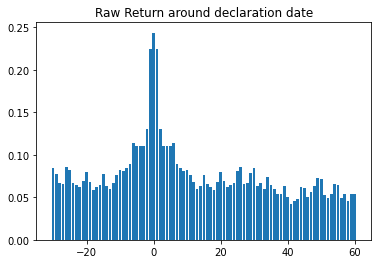

In [12]:
plt.bar(x,dlist)
plt.title('Raw Return around declaration date')
plt.show()

In [13]:
sum(d[0])

950.2755829999992

In [32]:
# c[c.DCLRDT.notna()]
# c[c.CUSIP=='05978R10'][4000:4500]

In [14]:
import pickle
filename = 'DCLRDT_Figure3.pkl'
with open(filename,'wb') as f:
    pickle.dump(dlist, f)

In [15]:
with open(filename,'rb') as f:
    a = pickle.load(f)
a == dlist

True